In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy.fftpack import fft,ifft
from schrodinger import Schrodinger
import matplotlib.pyplot as plt
import scipy
import sympy as sp

from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='jshtml')
import seaborn as sns

#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'serif', 'font.serif':'Times New Roman'})
sns.set_context('poster', font_scale=0.9,  rc={"lines.linewidth": 5})

In [4]:
# specify constants
hbar = 1.0   # planck's constant
m = 1.9      # particle mass
V0 = 3.0 #Potential value
E = 2.0  #Energy
a = 1.0 #Barrier size

In [14]:
#define x grid:
x = np.linspace(-50,50,500)

# specify potential at grid points
V_x = np.where(np.logical_and(0 < x, x < a), V0, 0)

### Transmission and reflection coefficients

In [25]:
@np.vectorize
def T(E,V0,a):
    k = np.sqrt(2*m*E)/hbar
    kp = np.sqrt(2*m*(V0-E))/hbar
    trans = 1
    trans += (((k**2+kp**2)**2)/(4*k**2*kp**2))*np.sinh(kp*a)**2
    return 1/trans

@np.vectorize
def R(E,V0,a):
    
    return 1 - T(E,V0,a)

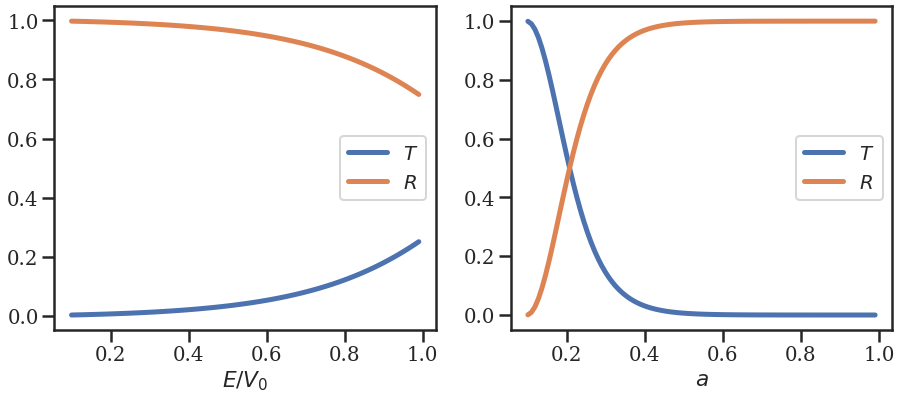

In [33]:
fig,ax = plt.subplots(ncols=2,figsize=(13,6),sharey=False)

evals = np.linspace(0.1*V0,0.99*V0,100)
ax[0].plot(evals/V0,T(E=evals,V0=V0,a=a),label=r'$T$')
ax[0].plot(evals/V0,R(E=evals,V0=V0,a=a),label=r'$R$')
ax[0].set_xlabel(r'$E/V_0$')
ax[0].legend()

avals = np.linspace(1e-2,3,100)
ax[1].plot(evals/V0,T(E=V0/2,V0=V0,a=avals),label=r'$T$')
ax[1].plot(evals/V0,R(E=V0/2,V0=V0,a=avals),label=r'$R$')
ax[1].set_xlabel(r'$a$')
ax[1].legend()

plt.tight_layout()
plt.savefig('coeffBarrier.png')
plt.show()

In [34]:
#Specify initial wave function at grid points:
@np.vectorize
def psiF(x,sigma=1.0,mu=-2.0,E=E):
    k0 = np.sqrt(2*m*E)/hbar
    f = np.exp(-(x-mu)**2/(4*sigma**2))
    f *= np.exp(np.complex(0,k0*x))
    
    return  f*E #Normalizarion so it is not much smaller than potential barrier in the plot

x0 = -20.0
psi_x0 = psiF(x=x,mu=x0,sigma=2.0)

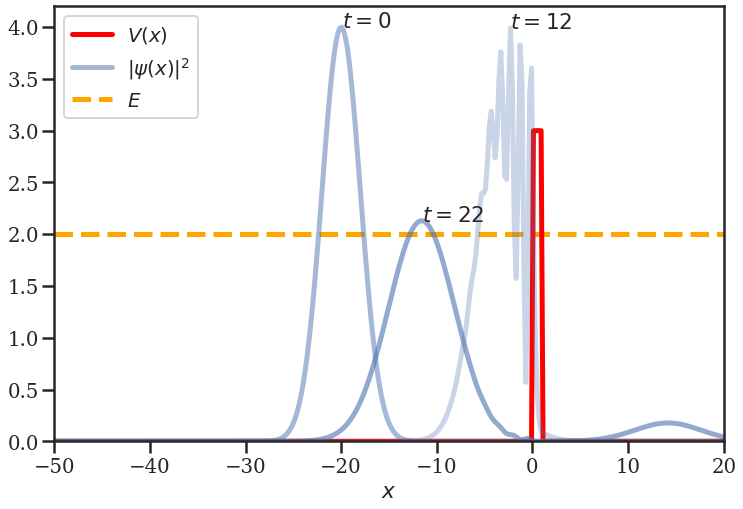

In [36]:
# Set up plot
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,8))
S = Schrodinger(x=x,  psi_x0=psi_x0, V_x=V_x, hbar=hbar, m=m)
plt.plot(x,V_x,linestyle='-',c='red',label=r'$V(x)$')
plt.hlines(y=E,xmin=x.min(),xmax=20,linestyle='--',color='orange',label=r'$E$')

l = plt.plot(S.x, np.abs(S.psi_x)**2,label=r'$|\psi(x)|^2$',alpha=0.5)
plt.annotate(r'$t = %1.0f$' %S.t,xy=(x[np.argmax(np.abs(S.psi_x)**2)],(np.abs(S.psi_x)**2).max()))

S.time_step(0.023, 500)
plt.plot(S.x, np.abs(S.psi_x)**2,alpha=0.3,c=l[0].get_color())
plt.annotate(r'$t = %1.0f$' %S.t,xy=(x[np.argmax(np.abs(S.psi_x)**2)],(np.abs(S.psi_x)**2).max()))

S.time_step(0.022, 500)
plt.plot(S.x, np.abs(S.psi_x)**2,alpha=0.6,c=l[0].get_color())
plt.annotate(r'$t = %1.0f$' %S.t,xy=(x[np.argmax(np.abs(S.psi_x)**2)],(np.abs(S.psi_x)**2).max()))

# S.time_step(0.025, 500)
# plt.plot(S.x, np.abs(S.psi_x)**2,alpha=1.0,c=l[0].get_color())
# plt.annotate(r'$t = %1.0f$' %S.t,xy=(x[np.argmax(np.abs(S.psi_x)**2)],(np.abs(S.psi_x)**2).max()))


plt.xlabel('$x$')
plt.xlim(x.min(),20)
plt.ylim(0,1.4*V0)
plt.legend(loc='upper left')


plt.savefig('potentialBarrier.png')
plt.show()

### Animation

In [39]:
######################################################################
# define the Schrodinger object which performs the calculations
S = Schrodinger(x=x,  psi_x0=psi_x0, V_x=V_x,
                    hbar=hbar, m=m)

# Set up plot
fig,ax1 = plt.subplots(nrows=1,ncols=1,figsize=(12,8))

psi_x_line, = ax1.plot([], [],label=r'$|\psi(x)|^2$')
ax1.plot(x,V_x,linestyle='-',c='red',label=r'$V(x)$')
ax1.hlines(y=E,xmin=x.min(),xmax=x.max(),linestyle='--',color='orange',label=r'$E$')
ax1.set_xlabel('$x$')
title = ax1.set_title("")
ax1.set_xlim(x.min(),x.max())
ax1.set_ylim(0,1.4*V0)
plt.legend(loc='upper left')


# Animate plot
def init():
    psi_x_line.set_data([], [])
    title.set_text("")
    return (psi_x_line, title)

def animate(i):
    S.time_step(dt, N_steps)
    psi_x_line.set_data(S.x, np.abs(S.psi_x)**2)

    title.set_text("t = %.2f" % S.t)
        
    return (psi_x_line, title)

# call the animator.  blit=True means only re-draw the parts that have changed.
dt = 0.01
N_steps = 50
t_max = 35
frames = int(t_max / float(N_steps * dt))

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=frames, interval=100, blit=True)

#Para salvar corretamente, tem que descomentar a linha de baixo
anim.save('schrodingerBarrier.mp4', fps=15, extra_args=['-vcodec', 'libx264'])

#Para ver o video no notebook deve comentar a linha de cima
plt.close()
anim
